In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from keras.models import Sequential
from keras.layers import *
from keras.optimizers import Adam

from keras.losses import MeanSquaredError
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteError
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

sns.set_theme(rc={'figure.figsize':(16,9)})

# Format code

In [2]:
def my_split_data(X, Y, test_ratio, verbose=False):
    k = round((1-test_ratio)*len(X))
    X_train, X_test = X[:k], X[k:]
    Y_train, Y_test = Y[:k], Y[k:]

    if verbose:
        print(f"Długość zbioru treningowego: {len(X_train)}, \nDługość zbioru testowego: {len(X_test)}, \nProcent jaki stanowi zbiór testowy: {test_ratio*100}%")

    return X_train, X_test, Y_train, Y_test


def format(df, window_size):
    arr = df.to_numpy()
    X, Y = [], []

    for i in range(len(arr)-window_size):
        row = [[a] for a in arr[i:i+window_size]]
        X.append(row)
        label = arr[i + window_size]
        Y.append(label)

    return np.array(X), np.array(Y)

# Evaluation code

In [3]:
def plot_loss(train_loss1, val_loss1, train_loss2, val_loss2):
    epochs = range(3, max(len(train_loss1),len(train_loss2)) + 1)
    plt.plot(epochs, train_loss1[2:], label='Model 1 training')
    plt.plot(epochs, val_loss1[2:], label='Model 1 validation')
    plt.plot(epochs, train_loss2[2:], label='Model 2 training')
    plt.plot(epochs, val_loss2[2:], label='Model 2 validation')
    plt.title('Training and Validation Loss (MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

def plot_predictions(df_predictions1, df_predictions2):
    plt.plot(df_predictions2.index, df_predictions2["Actuals"], label='Actuals', c="grey")
    plt.plot(df_predictions1.index, df_predictions1["Predictions"], label='Model 1', c="blue")
    plt.plot(df_predictions2.index, df_predictions2["Predictions"], label='Model 2', c="orange")
    plt.title('Predictions vs Actuals')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.xticks(rotation = 45)
    plt.legend()
    plt.show()


def error(y_true, y_pred):
    return [mean_absolute_error(y_true, y_pred), np.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_percentage_error(y_true, y_pred)]

def evaluate_metrics(df_predictions1, df_predictions2):
    df_error = pd.DataFrame([error(df_predictions1["Actuals"], df_predictions1["Predictions"]),
                             error(df_predictions2["Actuals"], df_predictions2["Predictions"])],
                             columns=["MAE","RMSE","MAPE"])
    return df_error

# MAIN

In [4]:
def main(filename="temperatures.csv", window_size=5, reccurent_layer=LSTM(64), epochs=100, lr=0.001, batch_size=30):

    df = pd.read_csv(filename, parse_dates=["Date"], index_col="Date").squeeze()
    df.index = pd.DatetimeIndex(df.index)
    index = df.index

    X, Y = format(df, window_size=window_size)
    X_train, X_test, Y_train, Y_test = my_split_data(X, Y, test_ratio=0.2)


    # Define model
    model = Sequential()
    model.add(InputLayer((window_size,1)))
    model.add(reccurent_layer)
    model.add(Dense(32, 'relu'))
    model.add(Dense(12, 'relu'))
    model.add(Dense(1, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=lr), metrics=[RootMeanSquaredError()])
    model.summary()

    model_fit = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=batch_size, epochs=epochs, verbose=True)

    # Get loss
    train_loss = model_fit.history['loss']
    val_loss = model_fit.history['val_loss']

    Y_predictions = model.predict(X_test).flatten()
    index_test = index[-len(X_test):]
    df_predictions = pd.DataFrame(data={'Predictions': Y_predictions, 'Actuals': Y_test}, index=index_test)

    return df_predictions, train_loss, val_loss

# Exploratory data analysis

In [5]:
df = pd.read_csv("temperatures.csv", parse_dates=["Date"], index_col="Date").squeeze()
df.head(7)

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
1981-01-06    15.8
1981-01-07    15.8
Name: Value, dtype: float64

In [6]:
df.describe()

count    3650.000000
mean       11.177753
std         4.071837
min         0.000000
25%         8.300000
50%        11.000000
75%        14.000000
max        26.300000
Name: Value, dtype: float64

In [7]:
df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Series name: Value
Non-Null Count  Dtype  
--------------  -----  
3650 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


<Axes: xlabel='Date'>

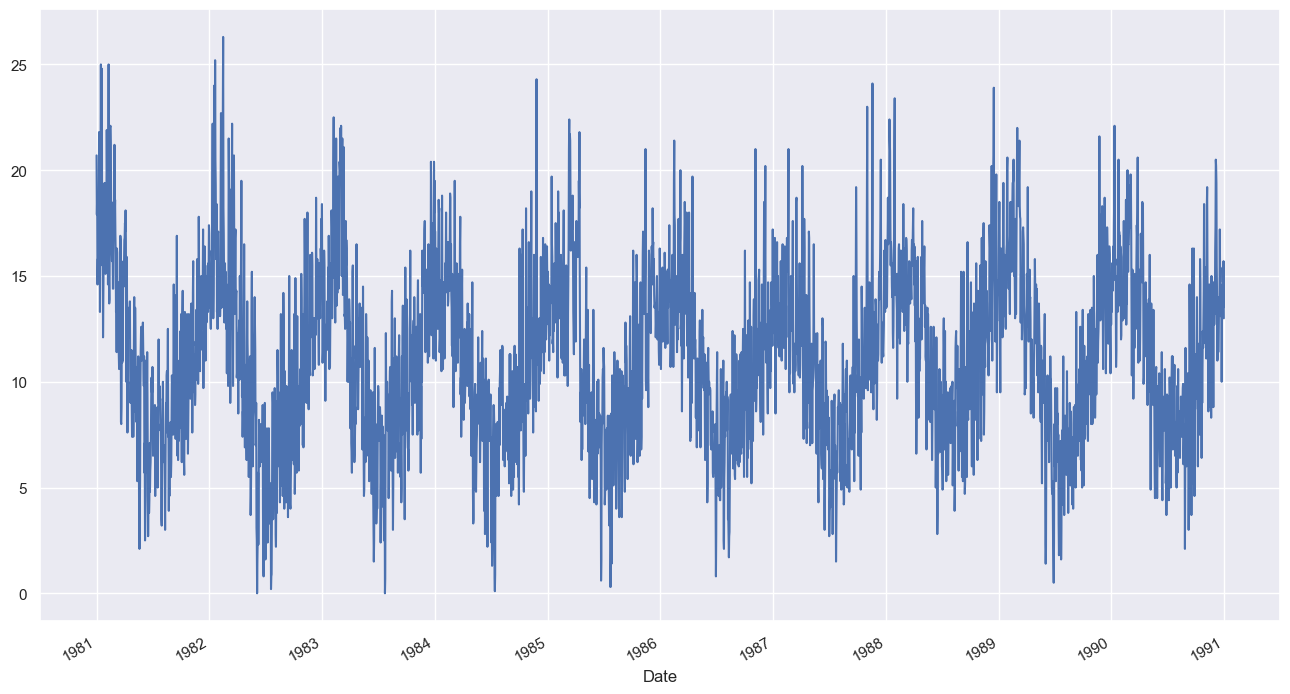

In [8]:
df.index = pd.DatetimeIndex(df.index)
index = df.index
df.plot()

# Examples

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 64)                16896     
                                                                 
 dense_39 (Dense)            (None, 32)                2080      
                                                                 
 dense_40 (Dense)            (None, 12)                396       
                                                                 
 dense_41 (Dense)            (None, 1)                 13        
                                                                 
Total params: 19385 (75.72 KB)
Trainable params: 19385 (75.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
98/98 [==============================] - 3s 8ms/step - loss: 98.9912 - root_mean_squared_error: 9.9494 - val_loss: 21.2372 - val_root_mea

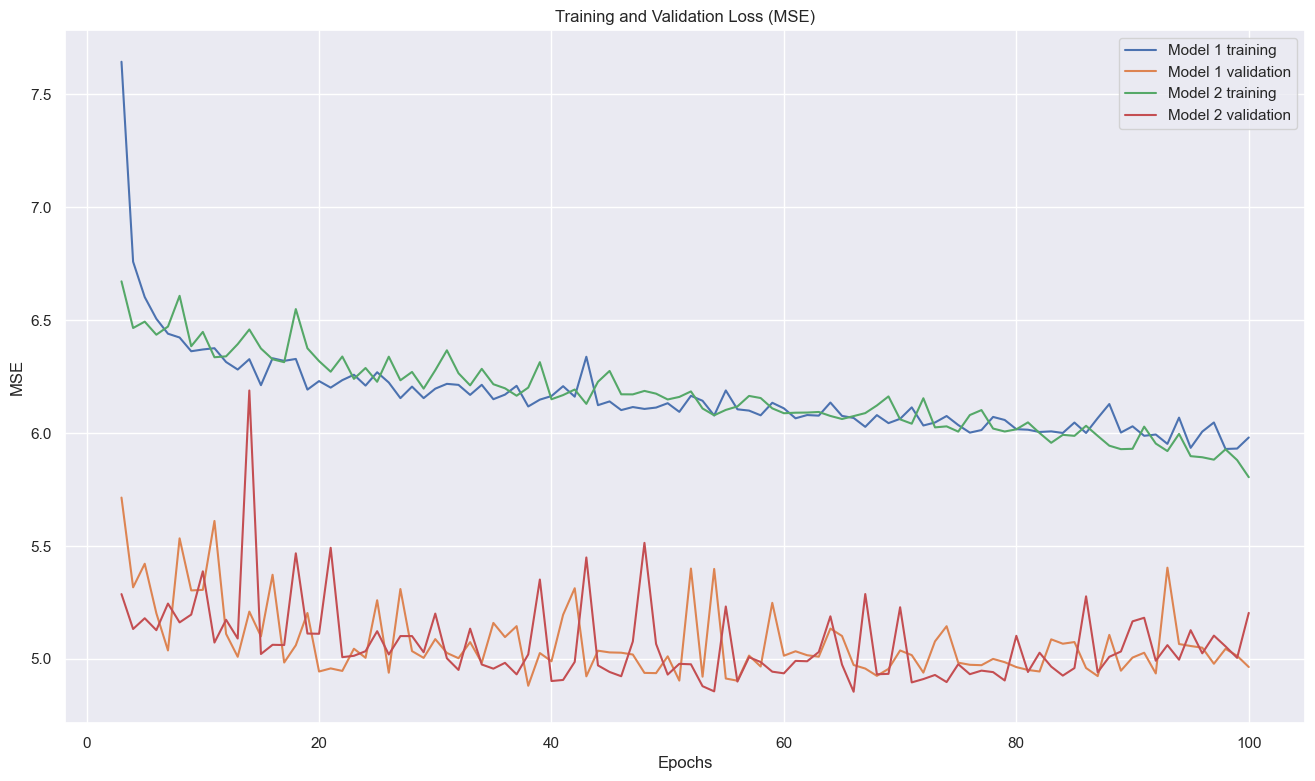

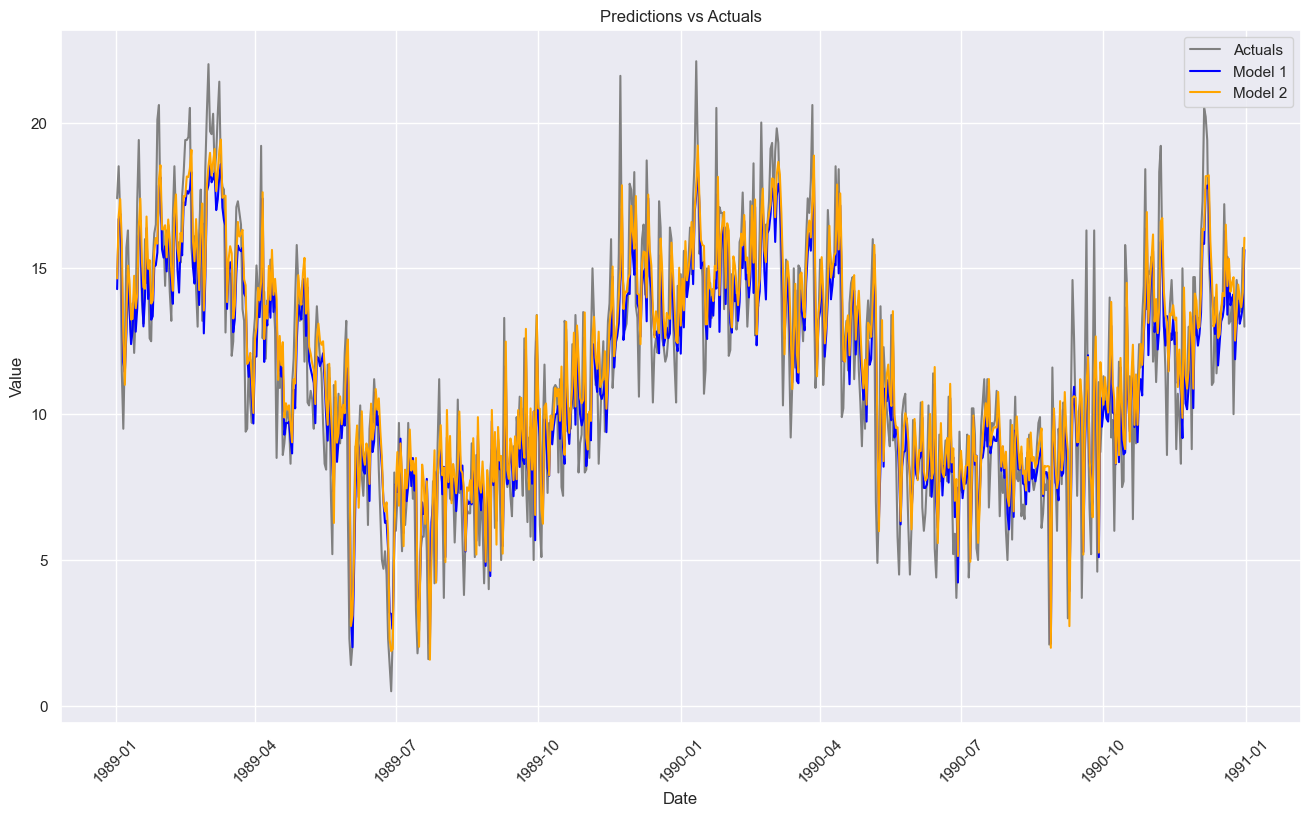

MAE      RMSE      MAPE
0  1.752844  2.227944  0.200217
1  1.800254  2.281052  0.210373

In [24]:
df_predictions1, train_loss1, val_loss1 = main()
df_predictions2, train_loss2, val_loss2 = main(reccurent_layer=LSTM(128))

plot_loss(train_loss1, val_loss1, train_loss2, val_loss2)
plot_predictions(df_predictions1, df_predictions2)
evaluate_metrics(df_predictions1, df_predictions2)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 64)                16896     
                                                                 
 dense_45 (Dense)            (None, 32)                2080      
                                                                 
 dense_46 (Dense)            (None, 12)                396       
                                                                 
 dense_47 (Dense)            (None, 1)                 13        
                                                                 
Total params: 19385 (75.72 KB)
Trainable params: 19385 (75.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
98/98 [==============================] - 3s 7ms/step - loss: 38.4133 - root_mean_squared_error: 6.1978 - val_loss: 8.0656 - val_root_mean

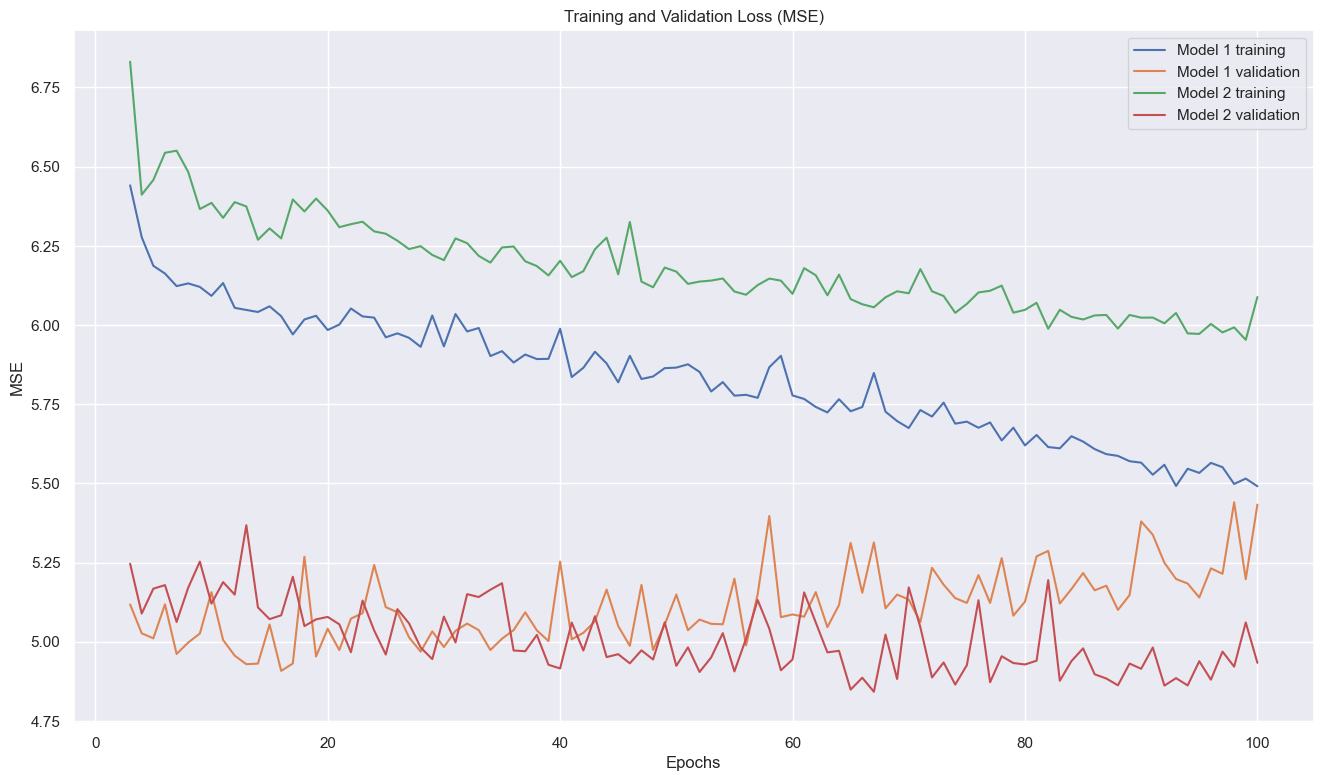

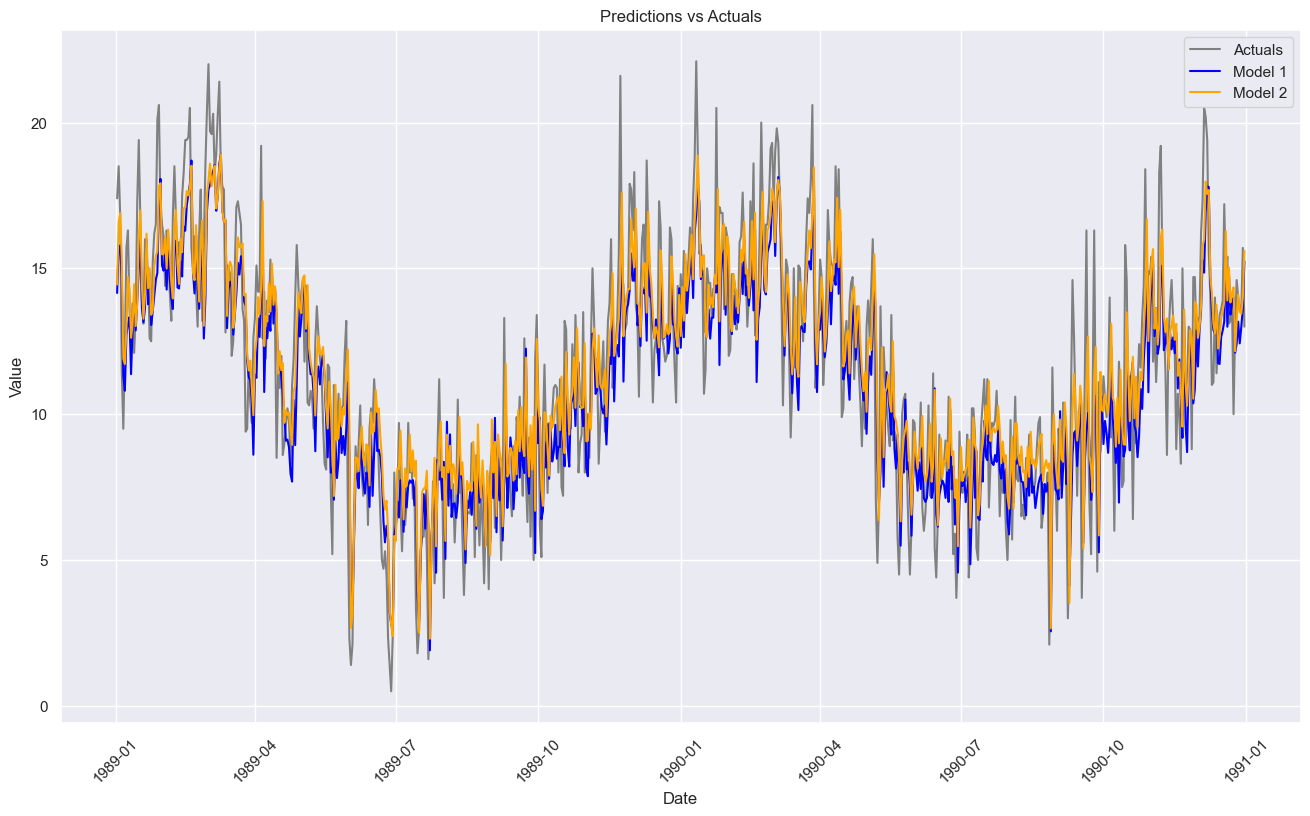

MAE      RMSE      MAPE
0  1.846275  2.330904  0.201434
1  1.743024  2.221250  0.204859

In [25]:
df_predictions1, train_loss1, val_loss1 = main()
df_predictions2, train_loss2, val_loss2 = main(reccurent_layer=LSTM(84))

plot_loss(train_loss1, val_loss1, train_loss2, val_loss2)
plot_predictions(df_predictions1, df_predictions2)
evaluate_metrics(df_predictions1, df_predictions2)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 64)                16896     
                                                                 
 dense_51 (Dense)            (None, 32)                2080      
                                                                 
 dense_52 (Dense)            (None, 12)                396       
                                                                 
 dense_53 (Dense)            (None, 1)                 13        
                                                                 
Total params: 19385 (75.72 KB)
Trainable params: 19385 (75.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
98/98 [==============================] - 3s 8ms/step - loss: 42.8916 - root_mean_squared_error: 6.5492 - val_loss: 9.8405 - val_root_mean

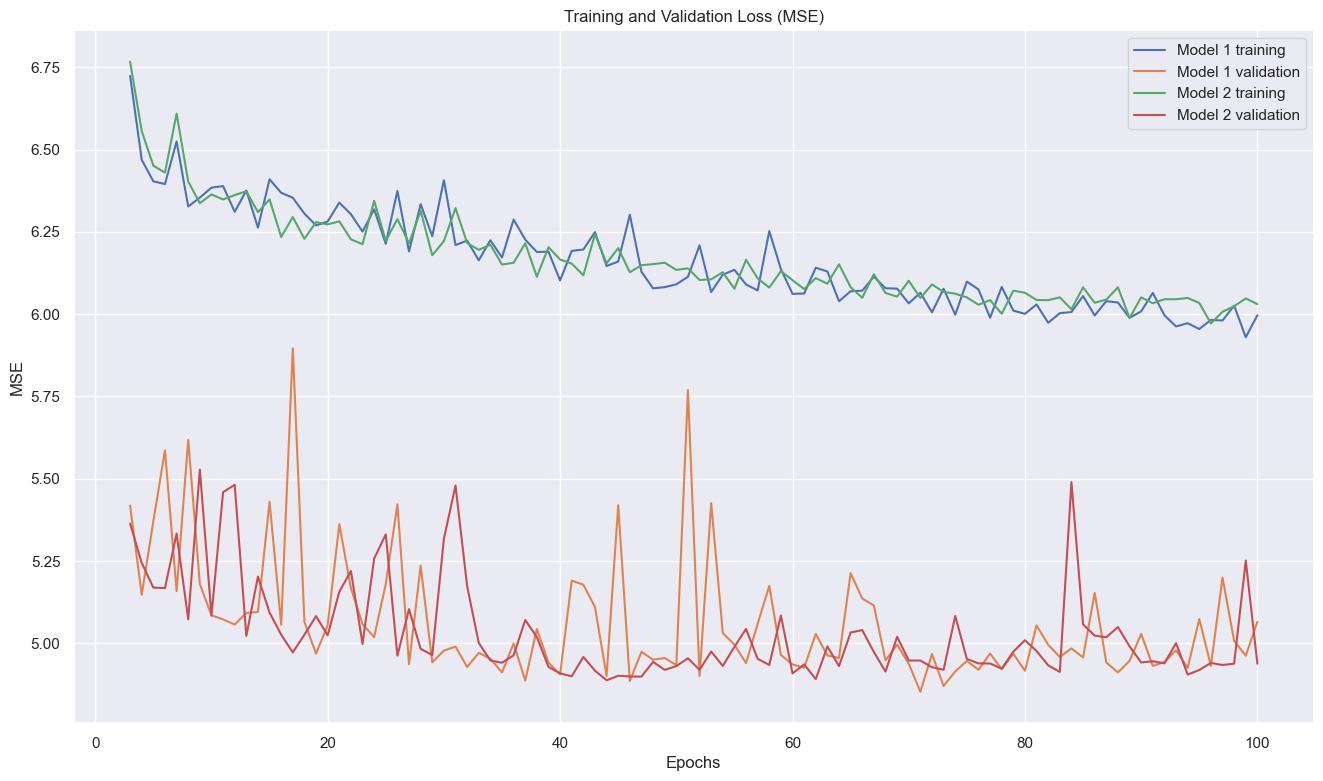

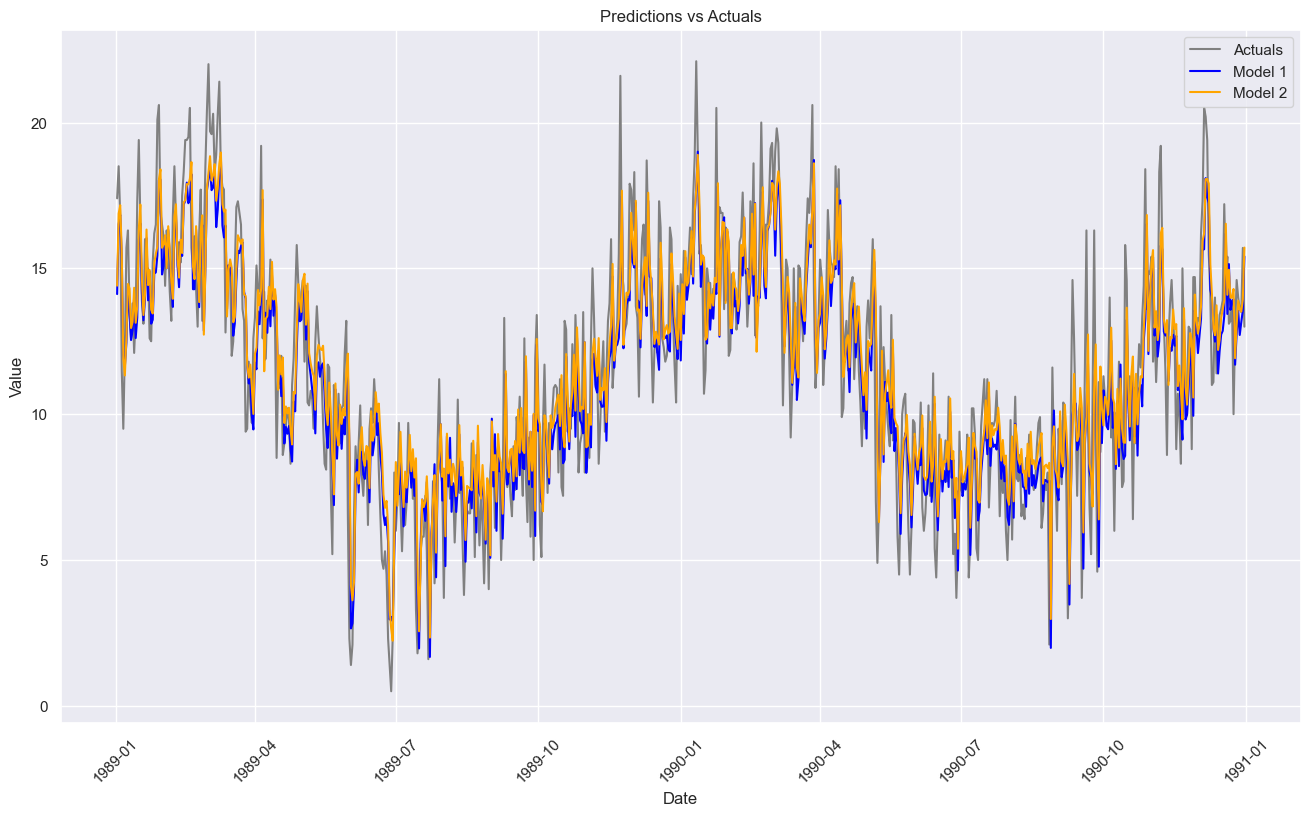

MAE      RMSE      MAPE
0  1.78080  2.250508  0.200187
1  1.74464  2.222019  0.205668

In [26]:
df_predictions1, train_loss1, val_loss1 = main(reccurent_layer=LSTM(64))
df_predictions2, train_loss2, val_loss2 = main(reccurent_layer=LSTM(46))

plot_loss(train_loss1, val_loss1, train_loss2, val_loss2)
plot_predictions(df_predictions1, df_predictions2)
evaluate_metrics(df_predictions1, df_predictions2)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 48)                9600      
                                                                 
 dense_57 (Dense)            (None, 32)                1568      
                                                                 
 dense_58 (Dense)            (None, 12)                396       
                                                                 
 dense_59 (Dense)            (None, 1)                 13        
                                                                 
Total params: 11577 (45.22 KB)
Trainable params: 11577 (45.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
98/98 [==============================] - 3s 7ms/step - loss: 33.6866 - root_mean_squared_error: 5.8040 - val_loss: 7.2413 - val_root_mean

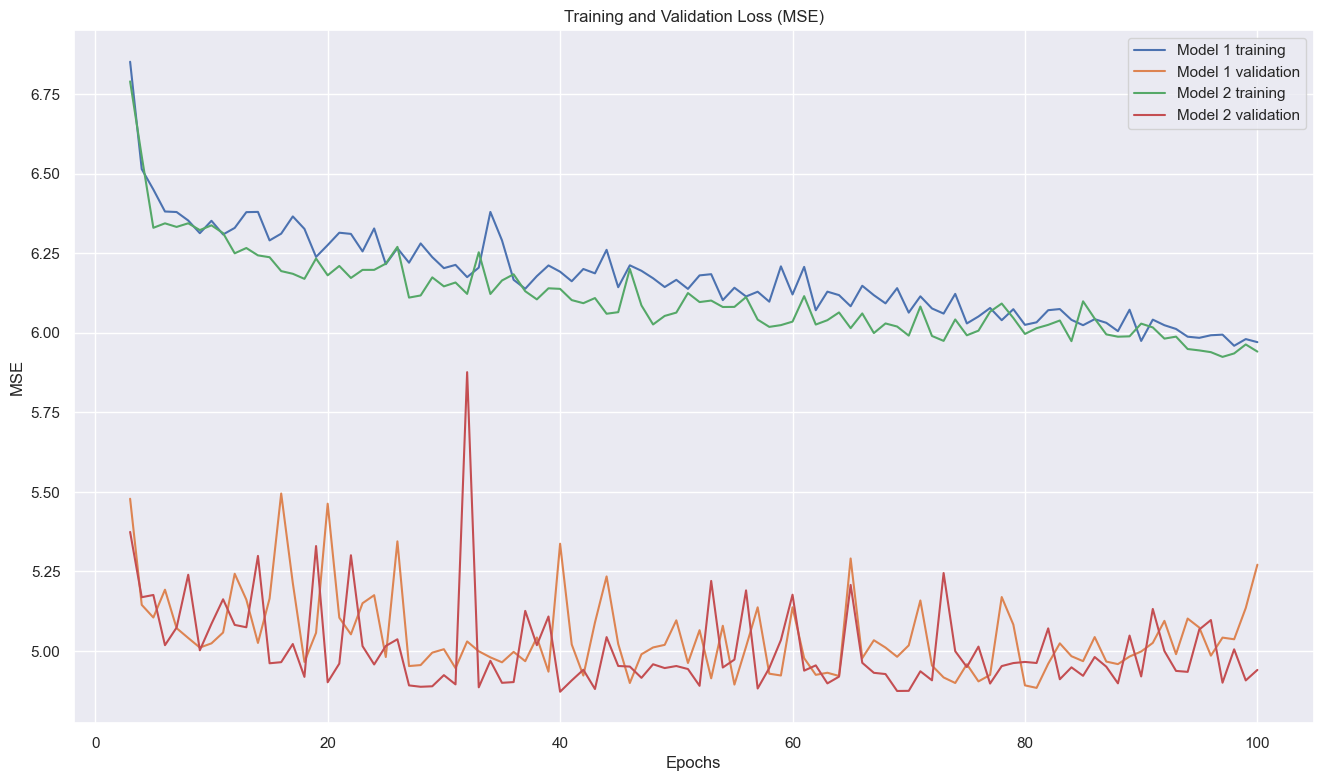

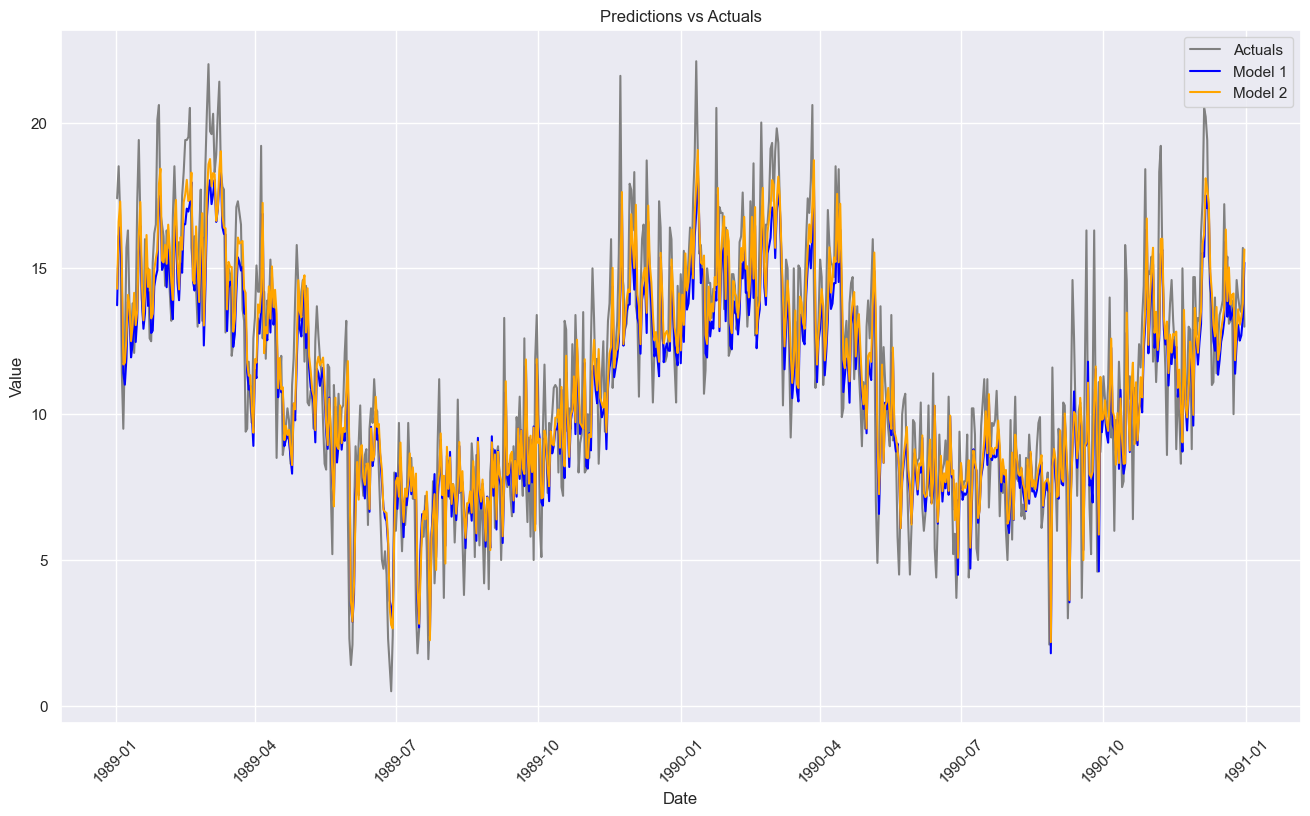

MAE      RMSE      MAPE
0  1.821718  2.295907  0.199386
1  1.747280  2.222751  0.197046

In [27]:
df_predictions1, train_loss1, val_loss1 = main(reccurent_layer=LSTM(48))
df_predictions2, train_loss2, val_loss2 = main(reccurent_layer=GRU(48))

plot_loss(train_loss1, val_loss1, train_loss2, val_loss2)
plot_predictions(df_predictions1, df_predictions2)
evaluate_metrics(df_predictions1, df_predictions2)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 48)                9600      
                                                                 
 dense_63 (Dense)            (None, 32)                1568      
                                                                 
 dense_64 (Dense)            (None, 12)                396       
                                                                 
 dense_65 (Dense)            (None, 1)                 13        
                                                                 
Total params: 11577 (45.22 KB)
Trainable params: 11577 (45.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
98/98 [==============================] - 2s 7ms/step - loss: 51.4576 - root_mean_squared_error: 7.1734 - val_loss: 13.1414 - val_root_mea

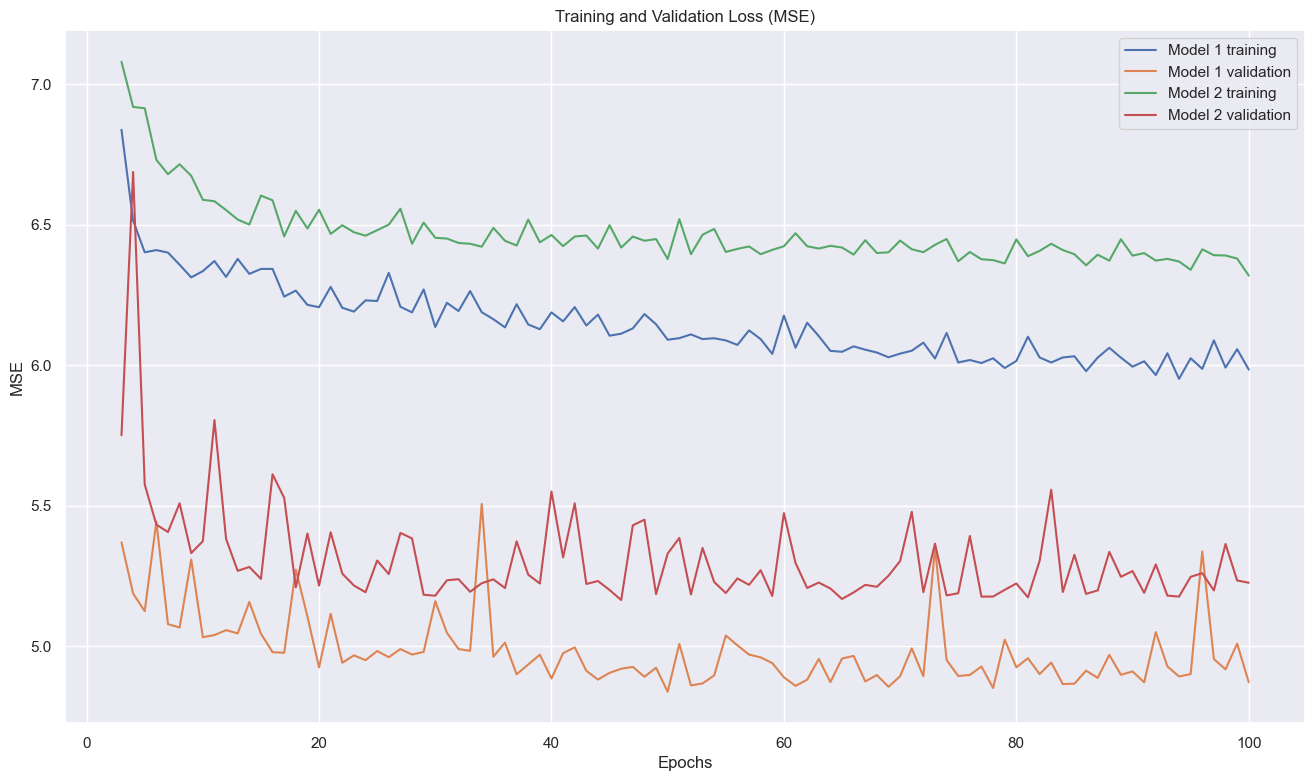

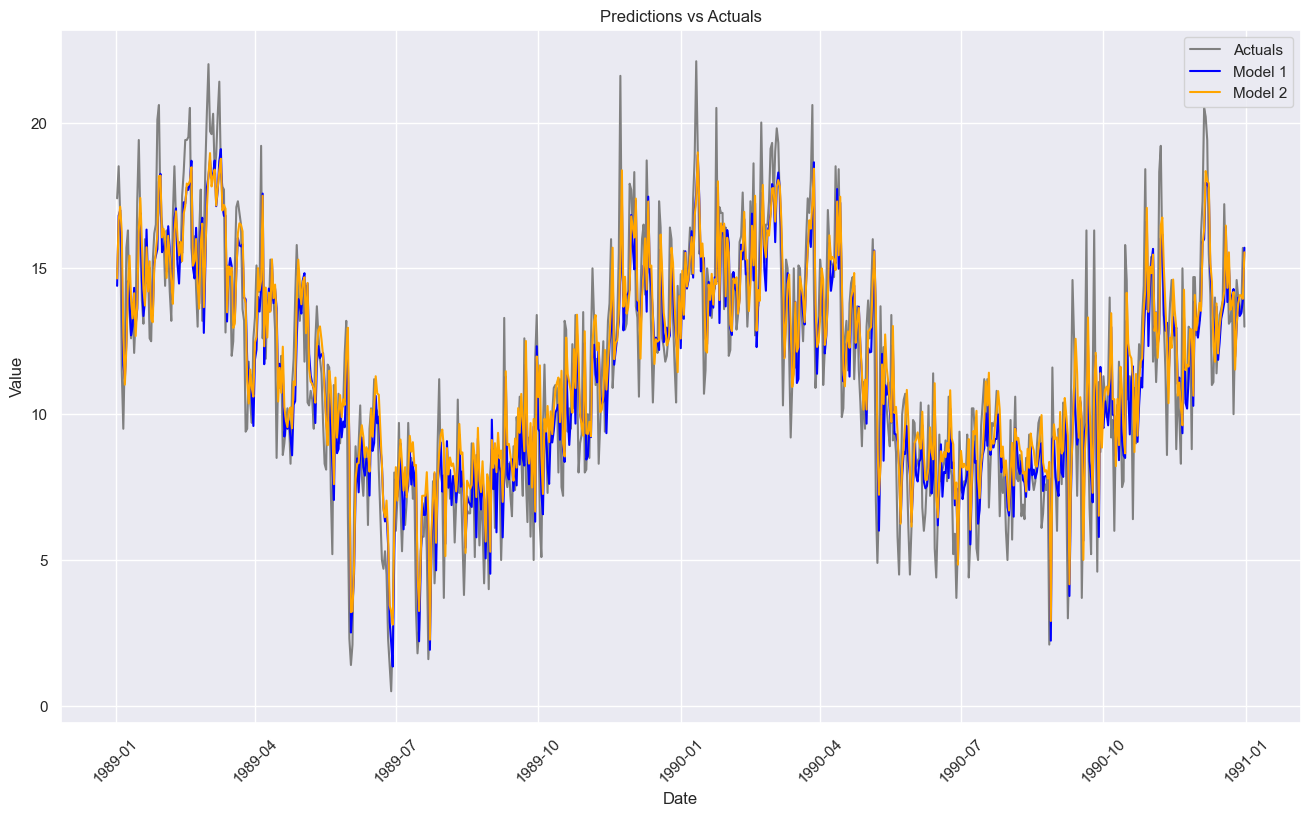

MAE      RMSE      MAPE
0  1.735871  2.207418  0.196877
1  1.805917  2.286140  0.215208

In [28]:
df_predictions1, train_loss1, val_loss1 = main(reccurent_layer=LSTM(48))
df_predictions2, train_loss2, val_loss2 = main(reccurent_layer=LSTM(48), window_size=3)

plot_loss(train_loss1, val_loss1, train_loss2, val_loss2)
plot_predictions(df_predictions1, df_predictions2)
evaluate_metrics(df_predictions1, df_predictions2)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 48)                9600      
                                                                 
 dense_81 (Dense)            (None, 32)                1568      
                                                                 
 dense_82 (Dense)            (None, 12)                396       
                                                                 
 dense_83 (Dense)            (None, 1)                 13        
                                                                 
Total params: 11577 (45.22 KB)
Trainable params: 11577 (45.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
98/98 [==============================] - 3s 7ms/step - loss: 52.2595 - root_mean_squared_error: 7.2291 - val_loss: 13.2877 - val_root_mea

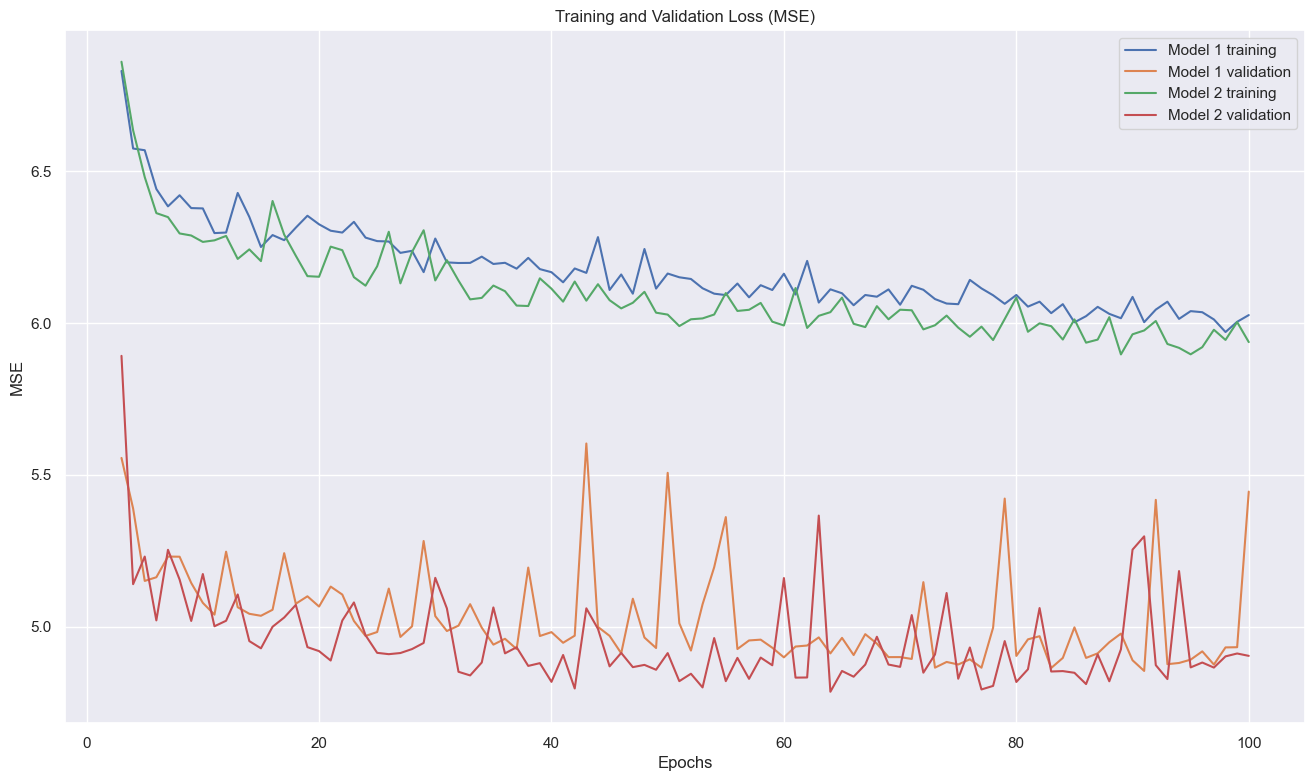

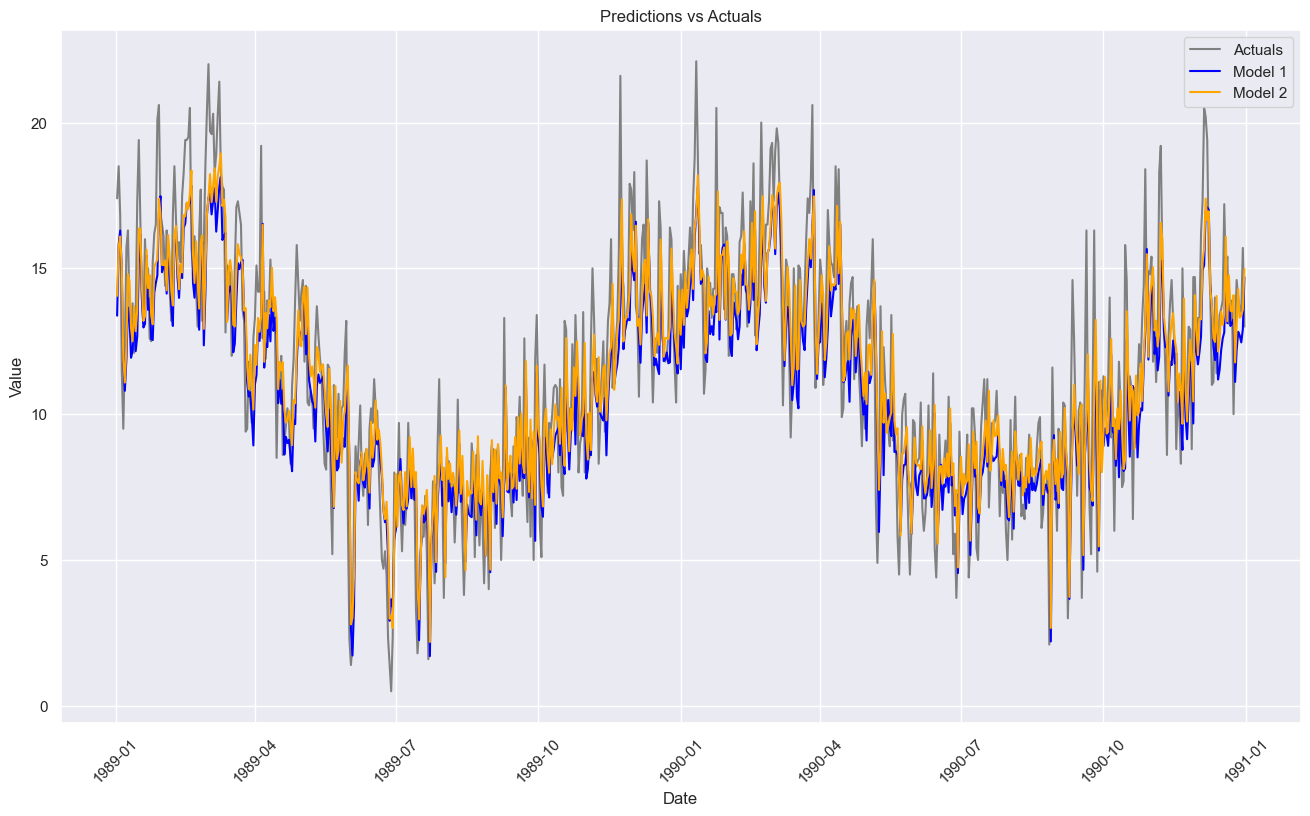

MAE      RMSE      MAPE
0  1.861288  2.333391  0.200172
1  1.750903  2.214532  0.199233

In [31]:
df_predictions1, train_loss1, val_loss1 = main(reccurent_layer=LSTM(48))
df_predictions2, train_loss2, val_loss2 = main(reccurent_layer=LSTM(48), window_size=7)

plot_loss(train_loss1, val_loss1, train_loss2, val_loss2)
plot_predictions(df_predictions1, df_predictions2)
evaluate_metrics(df_predictions1, df_predictions2)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 48)                9600      
                                                                 
 dense_93 (Dense)            (None, 32)                1568      
                                                                 
 dense_94 (Dense)            (None, 12)                396       
                                                                 
 dense_95 (Dense)            (None, 1)                 13        
                                                                 
Total params: 11577 (45.22 KB)
Trainable params: 11577 (45.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
98/98 [==============================] - 3s 7ms/step - loss: 53.1920 - root_mean_squared_error: 7.2933 - val_loss: 11.2349 - val_root_mea

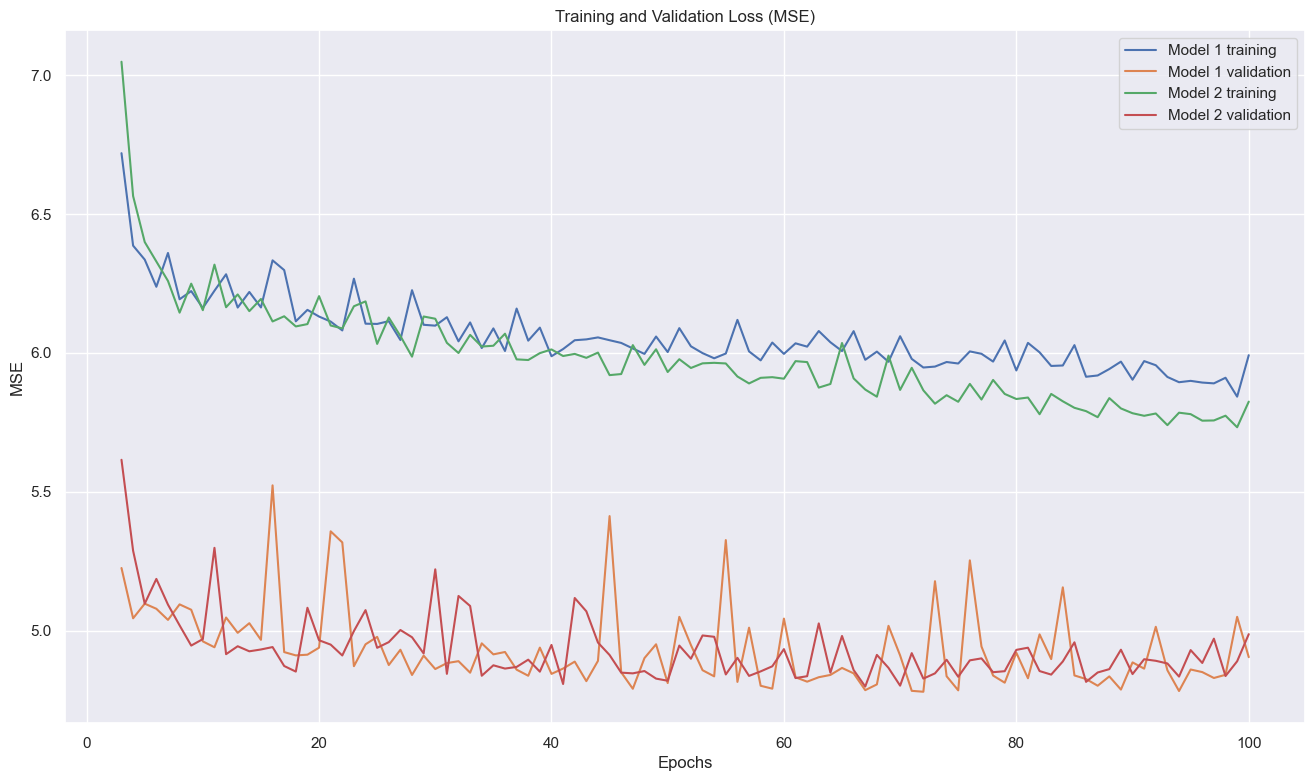

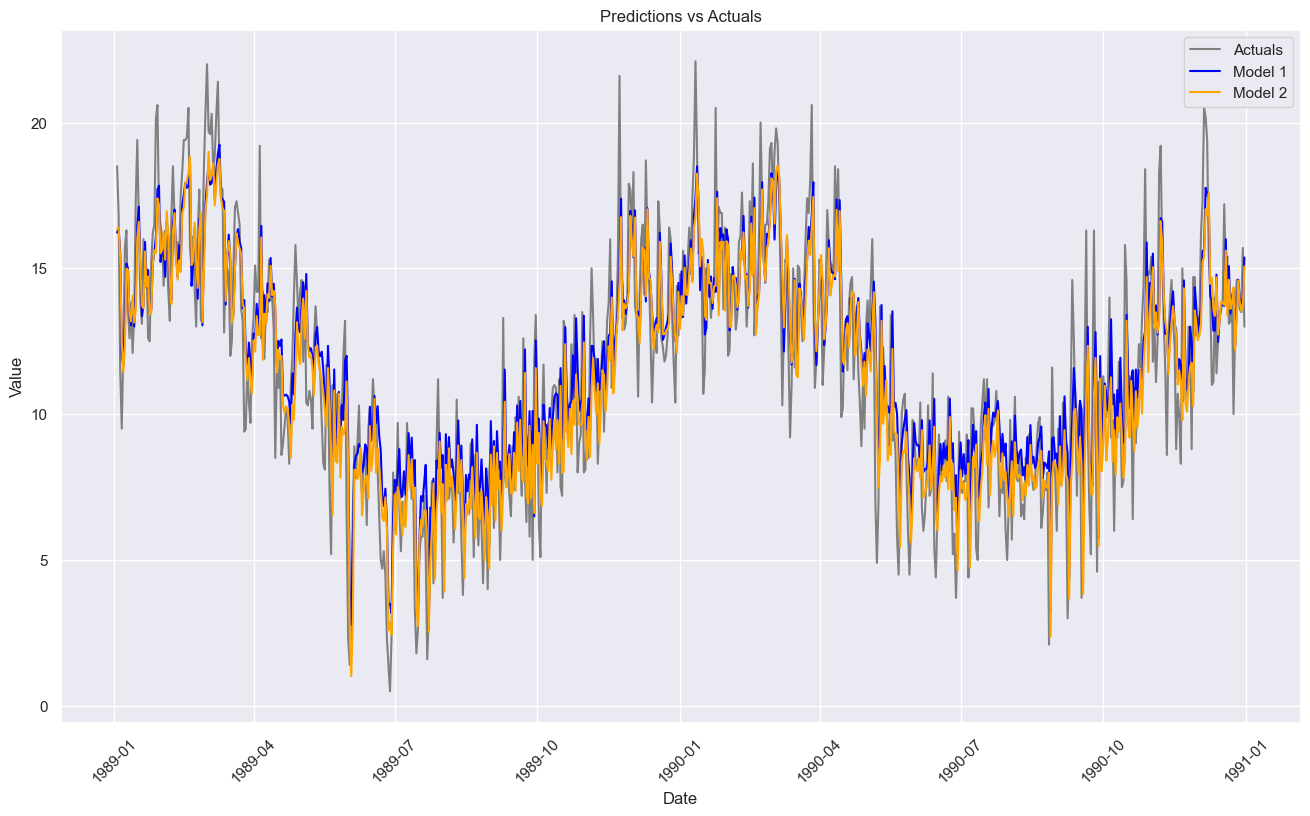

MAE      RMSE      MAPE
0  1.739394  2.214497  0.209652
1  1.771434  2.233113  0.196963

In [33]:
df_predictions1, train_loss1, val_loss1 = main(reccurent_layer=LSTM(48), window_size=8)
df_predictions2, train_loss2, val_loss2 = main(reccurent_layer=LSTM(48), window_size=10)

plot_loss(train_loss1, val_loss1, train_loss2, val_loss2)
plot_predictions(df_predictions1, df_predictions2)
evaluate_metrics(df_predictions1, df_predictions2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 48)                9600      
                                                                 
 dense (Dense)               (None, 32)                1568      
                                                                 
 dense_1 (Dense)             (None, 12)                396       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 11577 (45.22 KB)
Trainable params: 11577 (45.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100

98/98 [==============================] - 3s 9ms/step - loss: 56.1055 - root_mean_squared_error: 7.4904 - val_loss: 14.0998 - val_root_mean_

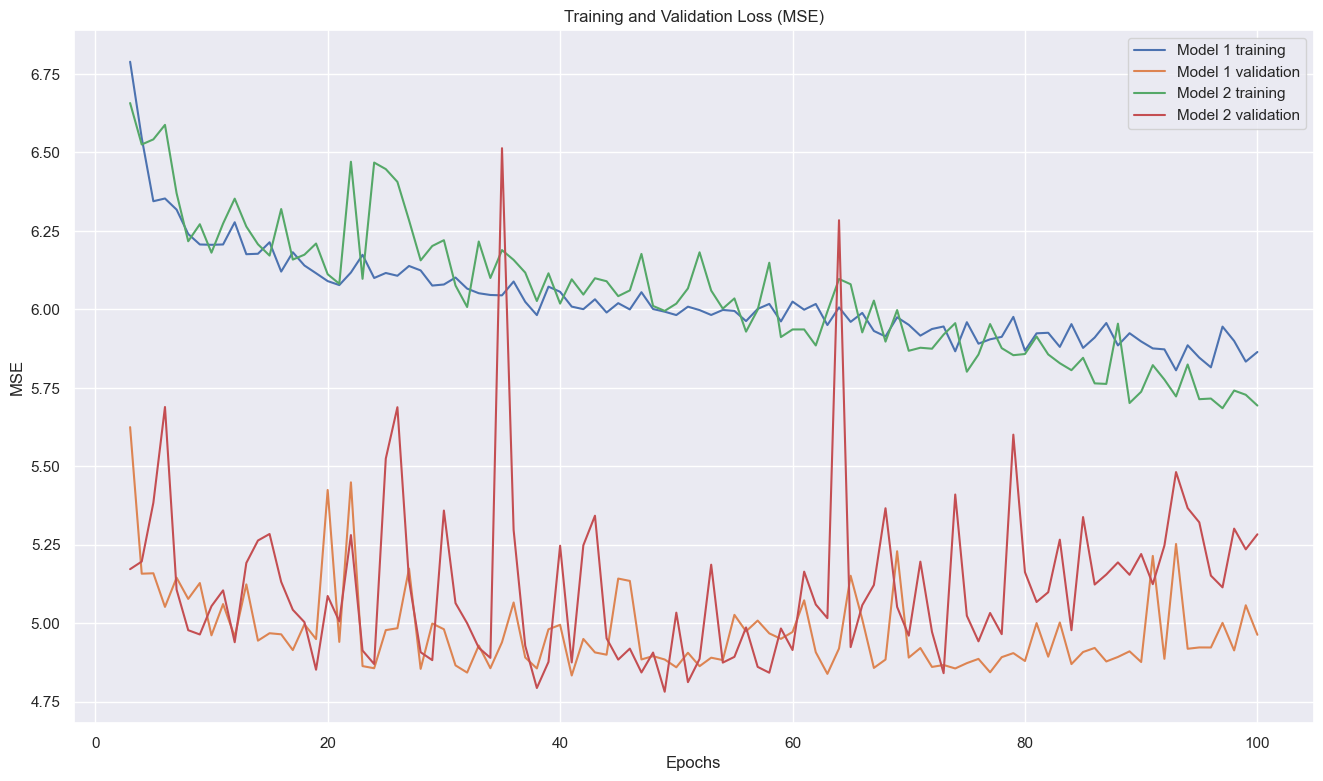

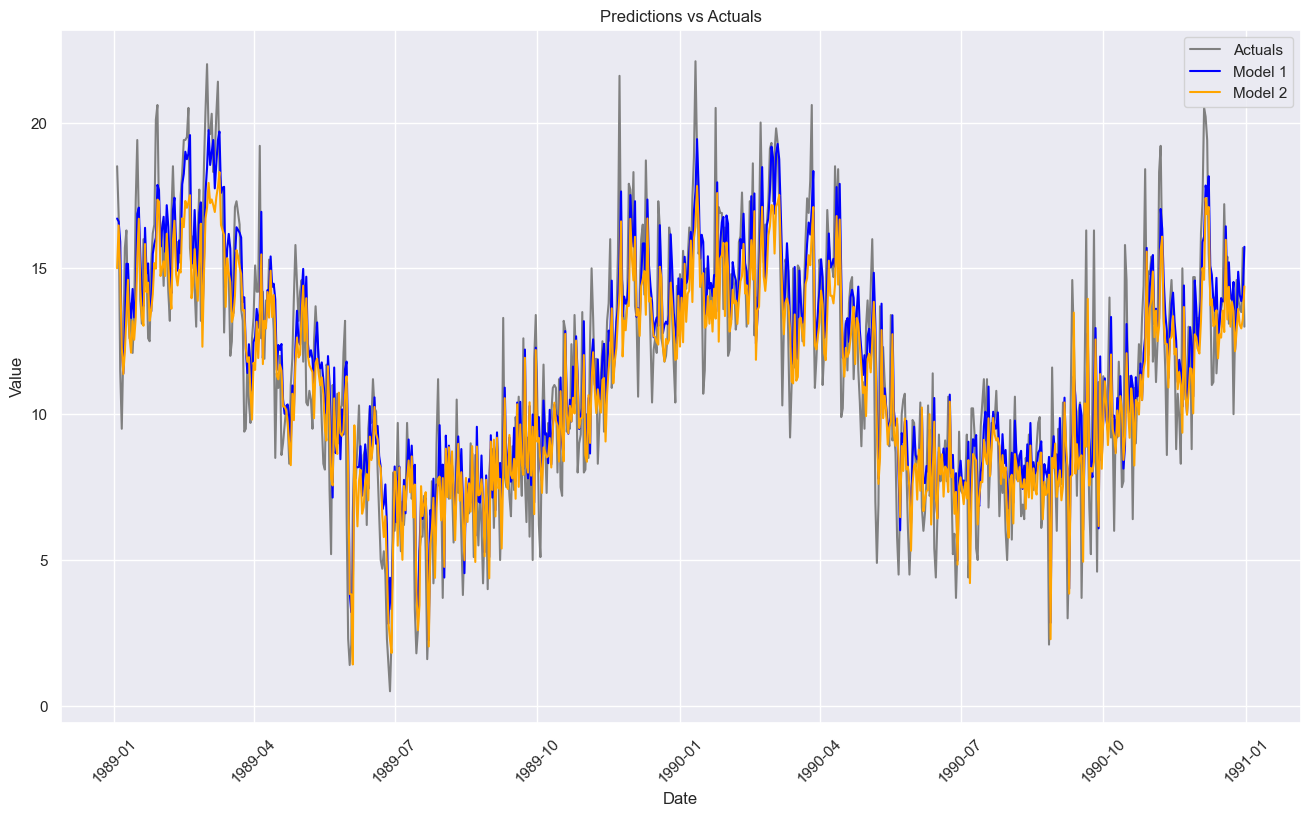

MAE      RMSE      MAPE
0  1.741385  2.227836  0.208808
1  1.828206  2.298563  0.200276

In [9]:
df_predictions1, train_loss1, val_loss1 = main(reccurent_layer=LSTM(48), window_size=8)
df_predictions2, train_loss2, val_loss2 = main(reccurent_layer=LSTM(48), window_size=8, lr=0.006)

plot_loss(train_loss1, val_loss1, train_loss2, val_loss2)
plot_predictions(df_predictions1, df_predictions2)
evaluate_metrics(df_predictions1, df_predictions2)

# Mortality examples

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 12)                396       
                                                                 
 dense_8 (Dense)             (None, 1)                 13        
                                                                 
Total params: 19385 (75.72 KB)
Trainable params: 19385 (75.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
68/68 [==============================] - 2s 8ms/step - loss: 7354.3022 - root_mean_squared_error: 85.7572 - val_loss: 4659.4458 - val_root

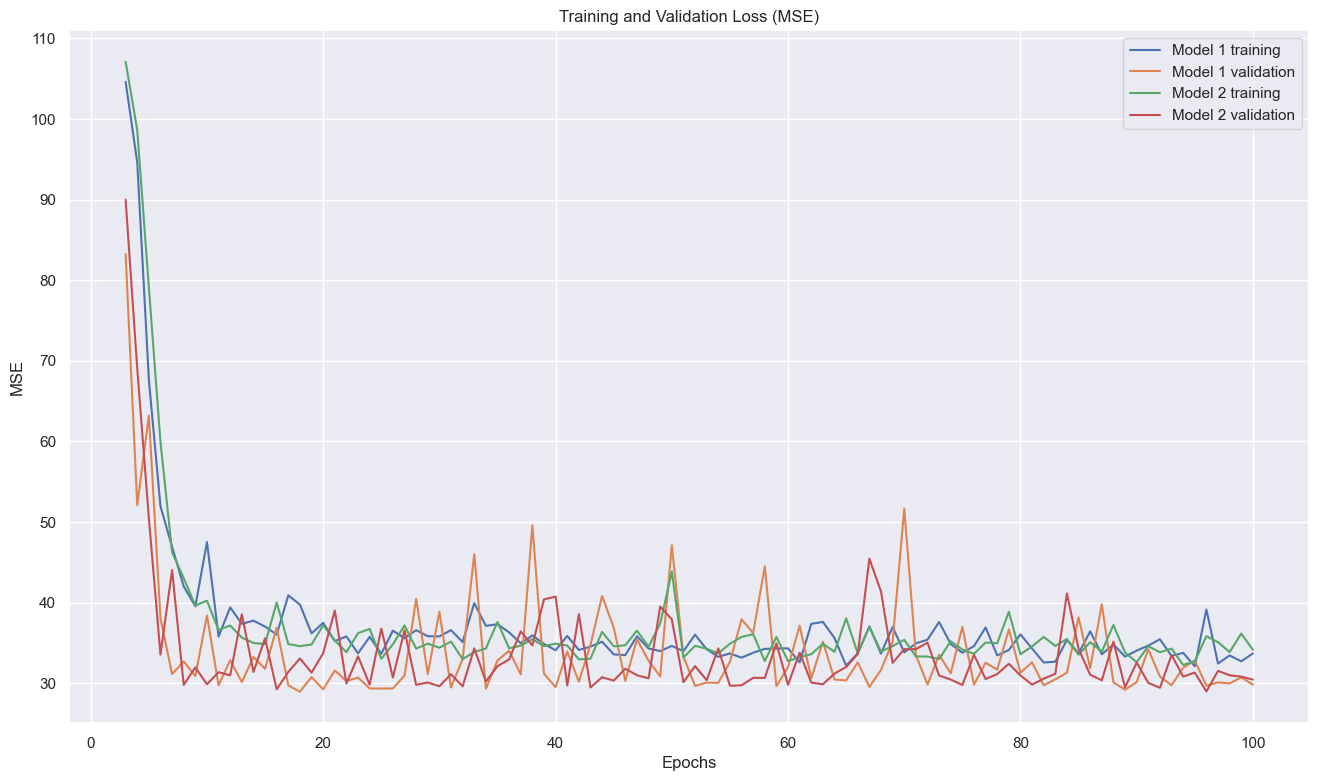

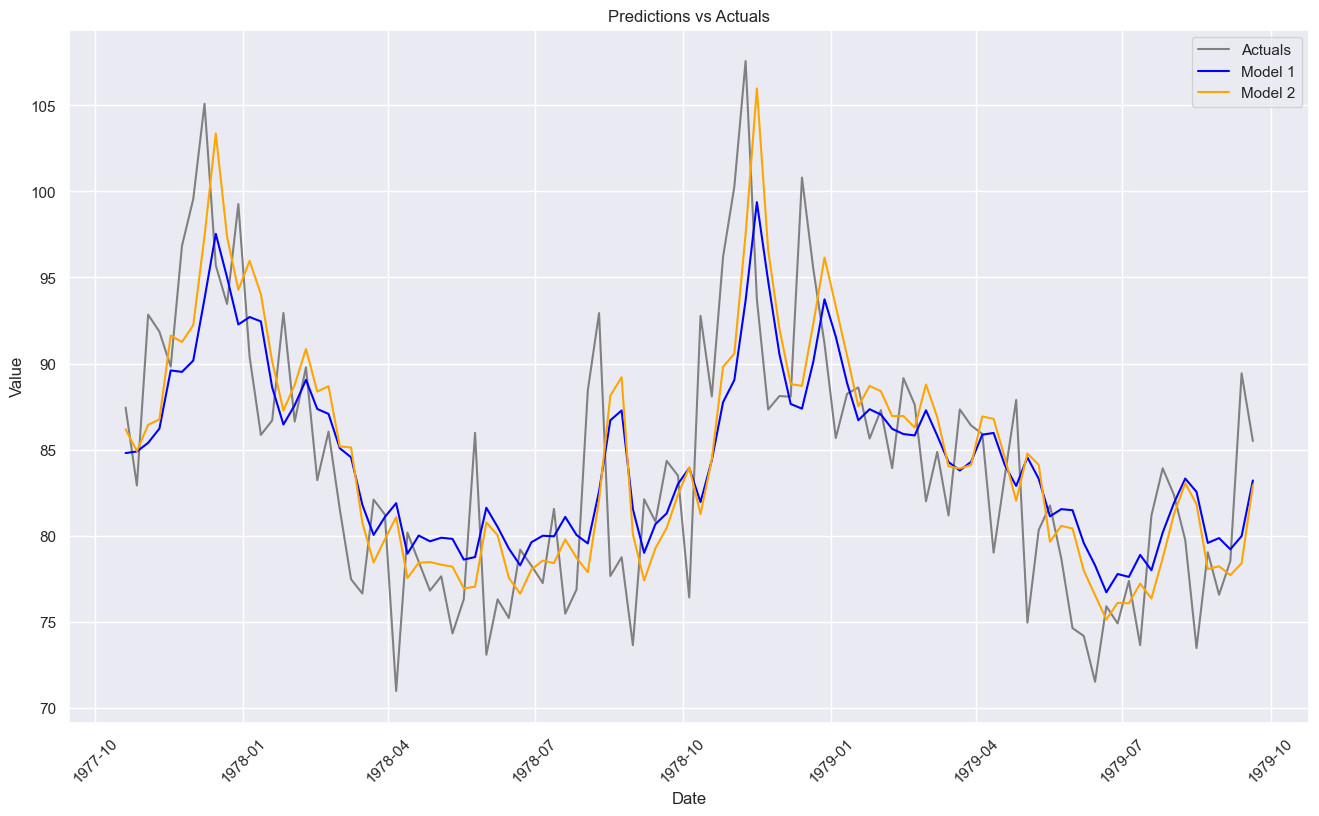

MAE      RMSE      MAPE
0  4.306371  5.460879  0.050894
1  4.486892  5.517355  0.052852

In [10]:
df_predictions1, train_loss1, val_loss1 = main(filename="mort.csv", reccurent_layer=LSTM(64), batch_size=6, window_size=4)
df_predictions2, train_loss2, val_loss2 = main(filename="mort.csv", reccurent_layer=LSTM(128), batch_size=6, window_size=4)

plot_loss(train_loss1, val_loss1, train_loss2, val_loss2)
plot_predictions(df_predictions1, df_predictions2)
evaluate_metrics(df_predictions1, df_predictions2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 12)                396       
                                                                 
 dense_14 (Dense)            (None, 1)                 13        
                                                                 
Total params: 19385 (75.72 KB)
Trainable params: 19385 (75.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
68/68 [==============================] - 3s 9ms/step - loss: 7097.1118 - root_mean_squared_error: 84.2444 - val_loss: 4357.4722 - val_root

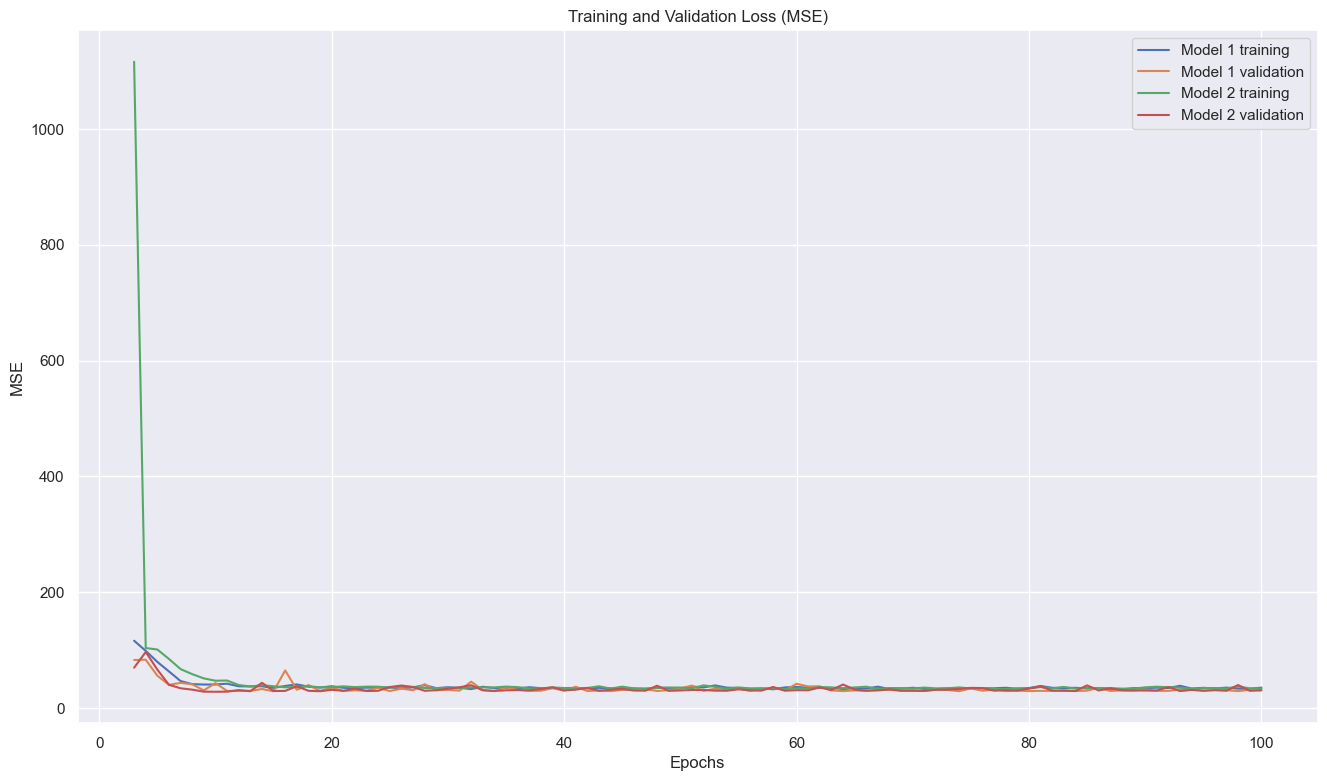

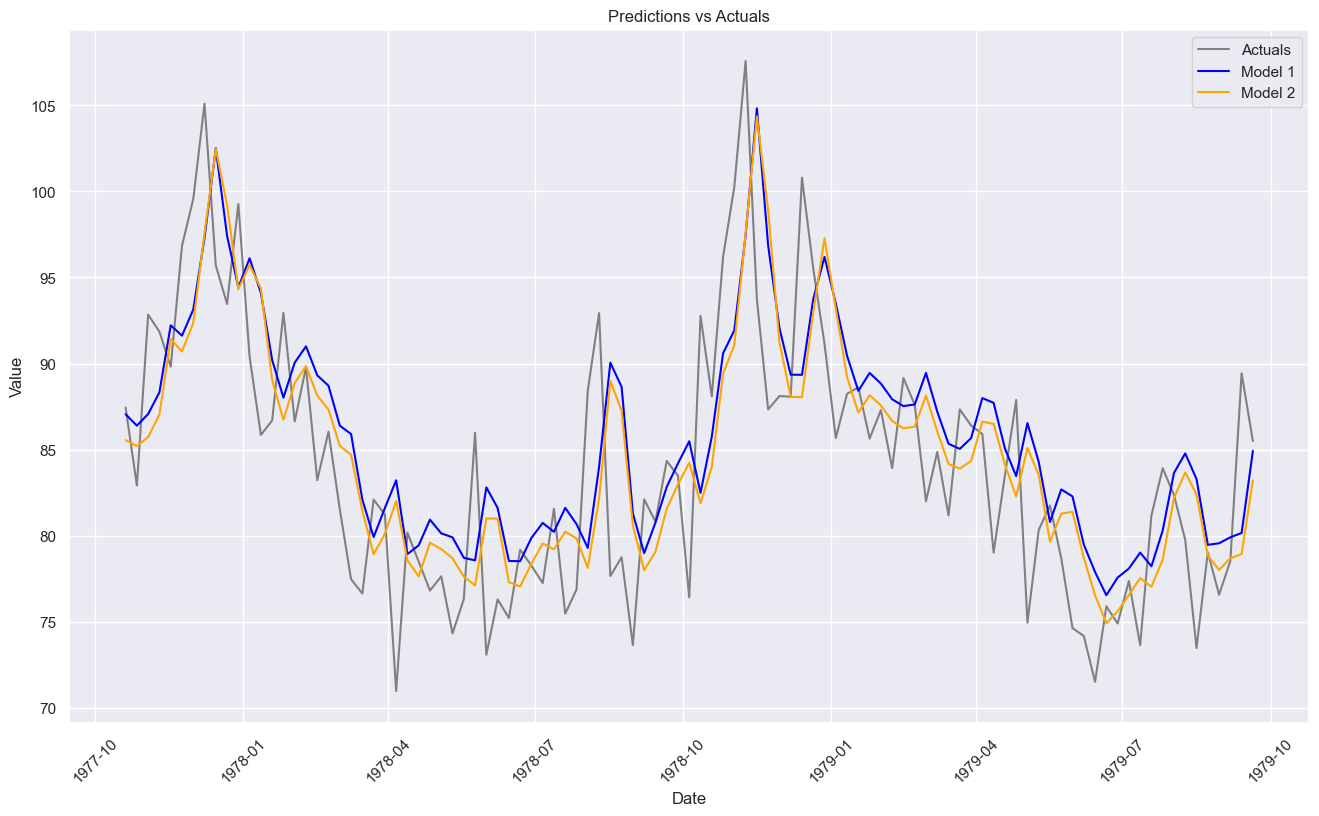

MAE      RMSE      MAPE
0  4.601383  5.639391  0.055002
1  4.448810  5.542344  0.052541

In [11]:
df_predictions1, train_loss1, val_loss1 = main(filename="mort.csv", reccurent_layer=LSTM(64), batch_size=6, window_size=4)
df_predictions2, train_loss2, val_loss2 = main(filename="mort.csv", reccurent_layer=LSTM(46), batch_size=6, window_size=4)

plot_loss(train_loss1, val_loss1, train_loss2, val_loss2)
plot_predictions(df_predictions1, df_predictions2)
evaluate_metrics(df_predictions1, df_predictions2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 46)                8832      
                                                                 
 dense_18 (Dense)            (None, 32)                1504      
                                                                 
 dense_19 (Dense)            (None, 12)                396       
                                                                 
 dense_20 (Dense)            (None, 1)                 13        
                                                                 
Total params: 10745 (41.97 KB)
Trainable params: 10745 (41.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
68/68 [==============================] - 3s 9ms/step - loss: 7098.1494 - root_mean_squared_error: 84.2505 - val_loss: 4462.3540 - val_root

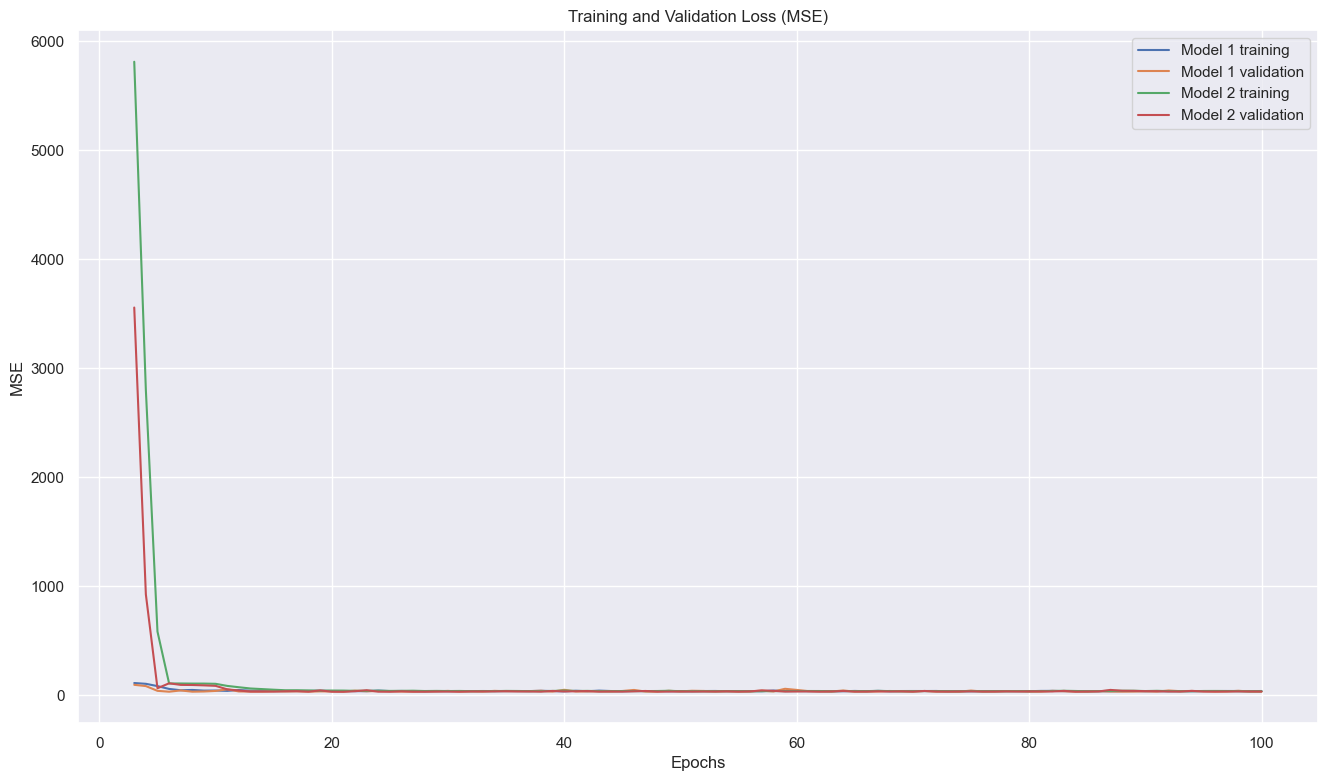

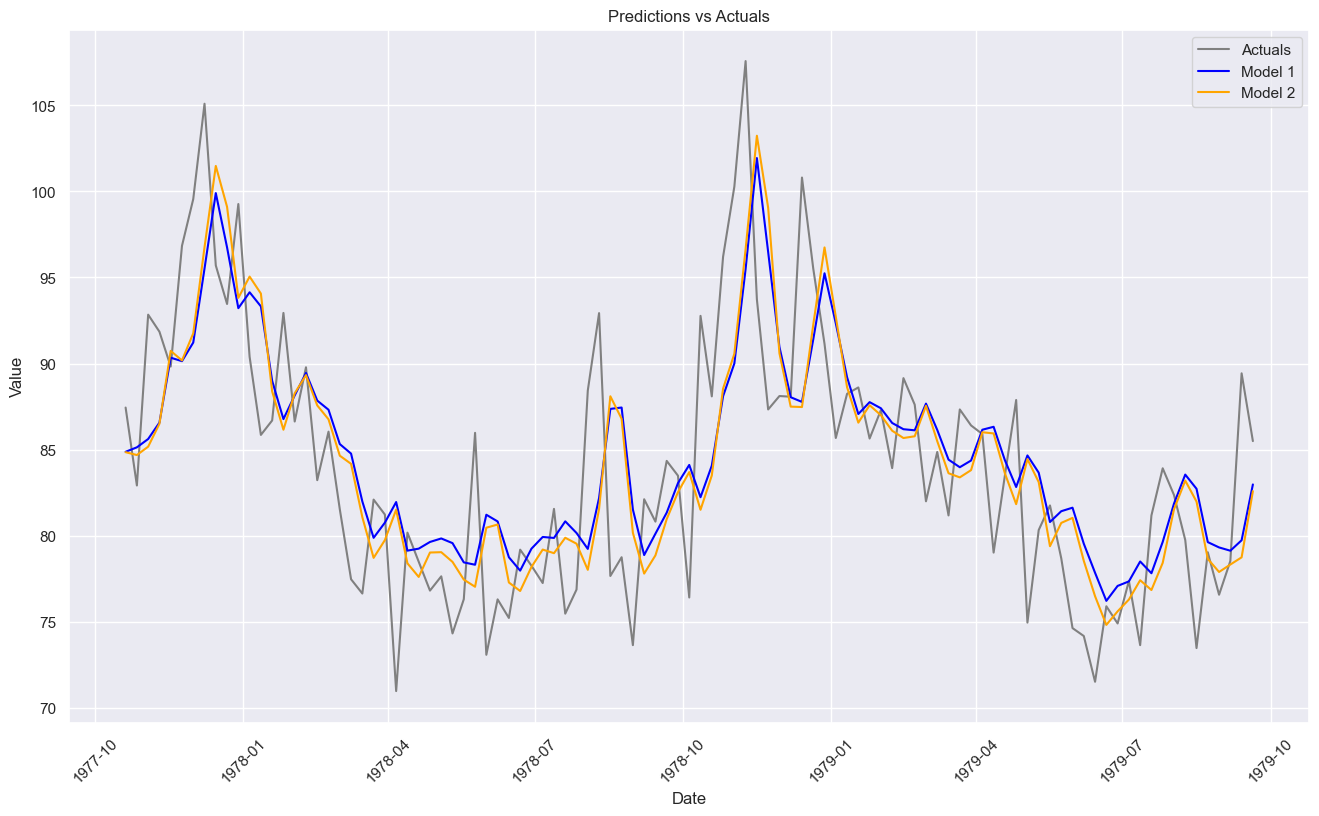

MAE      RMSE      MAPE
0  4.381664  5.459167  0.051822
1  4.404673  5.510331  0.051781

In [12]:
df_predictions1, train_loss1, val_loss1 = main(filename="mort.csv", reccurent_layer=LSTM(46), batch_size=6, window_size=4)
df_predictions2, train_loss2, val_loss2 = main(filename="mort.csv", reccurent_layer=LSTM(46), batch_size=12, window_size=4)

plot_loss(train_loss1, val_loss1, train_loss2, val_loss2)
plot_predictions(df_predictions1, df_predictions2)
evaluate_metrics(df_predictions1, df_predictions2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 46)                8832      
                                                                 
 dense_24 (Dense)            (None, 32)                1504      
                                                                 
 dense_25 (Dense)            (None, 12)                396       
                                                                 
 dense_26 (Dense)            (None, 1)                 13        
                                                                 
Total params: 10745 (41.97 KB)
Trainable params: 10745 (41.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
68/68 [==============================] - 3s 9ms/step - loss: 7960.6689 - root_mean_squared_error: 89.2226 - val_loss: 6573.9028 - val_root

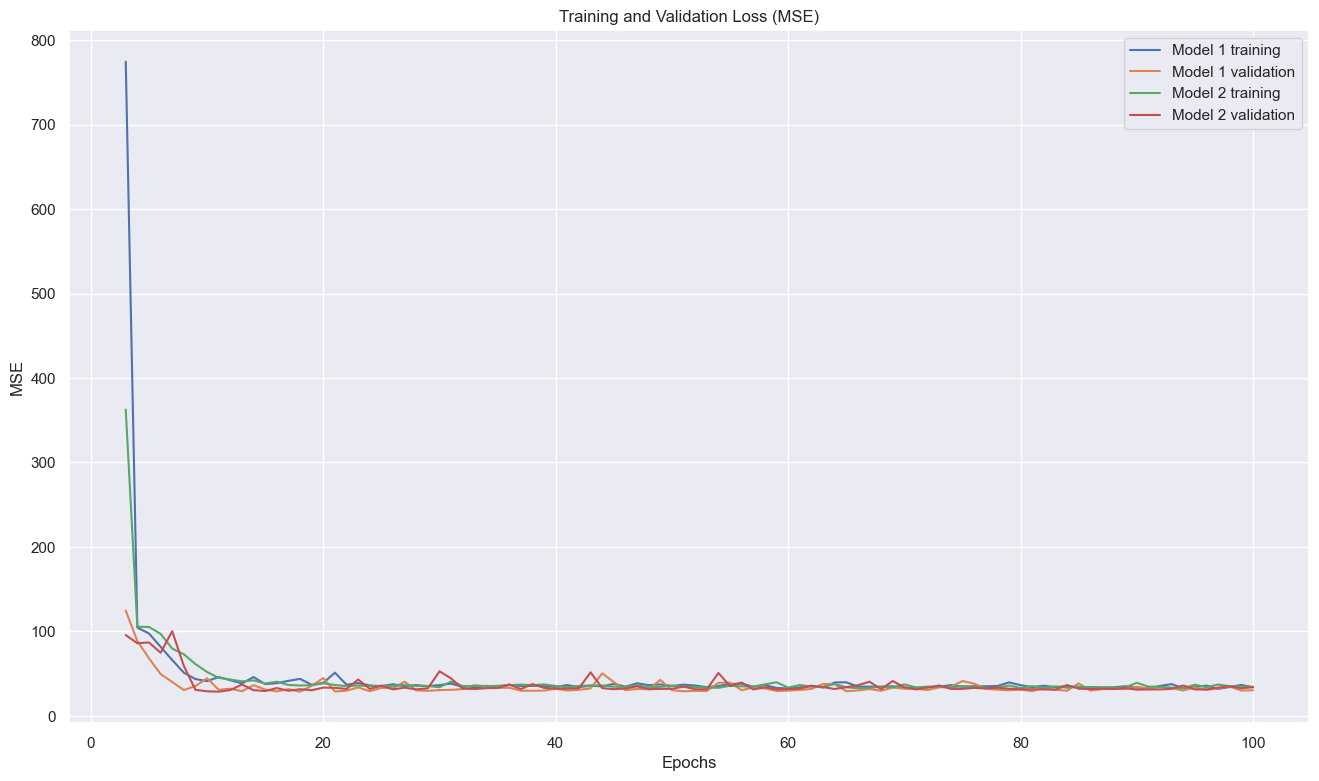

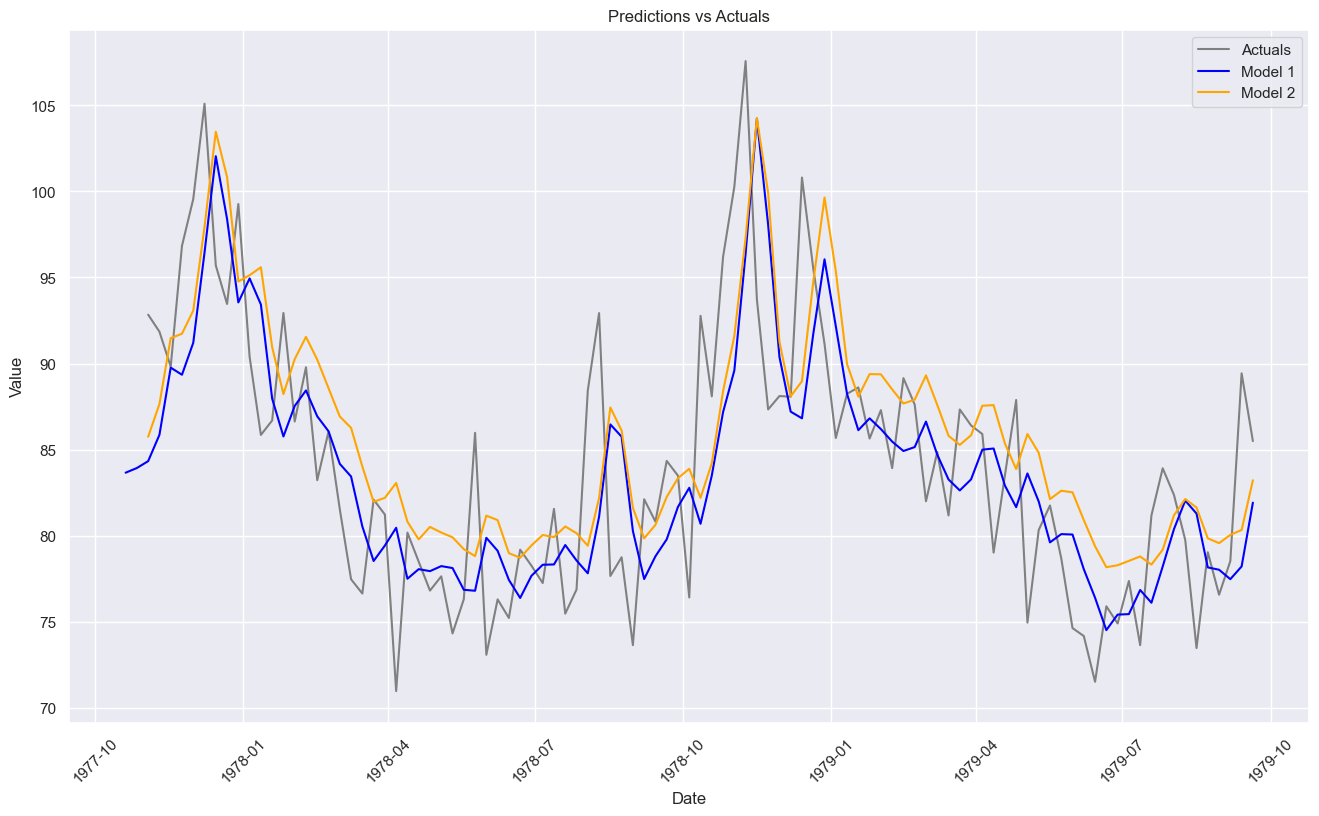

MAE      RMSE      MAPE
0  4.372252  5.504264  0.051034
1  4.775985  5.825919  0.056868

In [13]:
df_predictions1, train_loss1, val_loss1 = main(filename="mort.csv", reccurent_layer=LSTM(46), batch_size=6, window_size=4)
df_predictions2, train_loss2, val_loss2 = main(filename="mort.csv", reccurent_layer=LSTM(46), batch_size=6, window_size=12)

plot_loss(train_loss1, val_loss1, train_loss2, val_loss2)
plot_predictions(df_predictions1, df_predictions2)
evaluate_metrics(df_predictions1, df_predictions2)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 46)                8832      
                                                                 
 dense_30 (Dense)            (None, 32)                1504      
                                                                 
 dense_31 (Dense)            (None, 12)                396       
                                                                 
 dense_32 (Dense)            (None, 1)                 13        
                                                                 
Total params: 10745 (41.97 KB)
Trainable params: 10745 (41.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
68/68 [==============================] - 3s 9ms/step - loss: 7950.4678 - root_mean_squared_error: 89.1654 - val_loss: 6447.5791 - val_roo

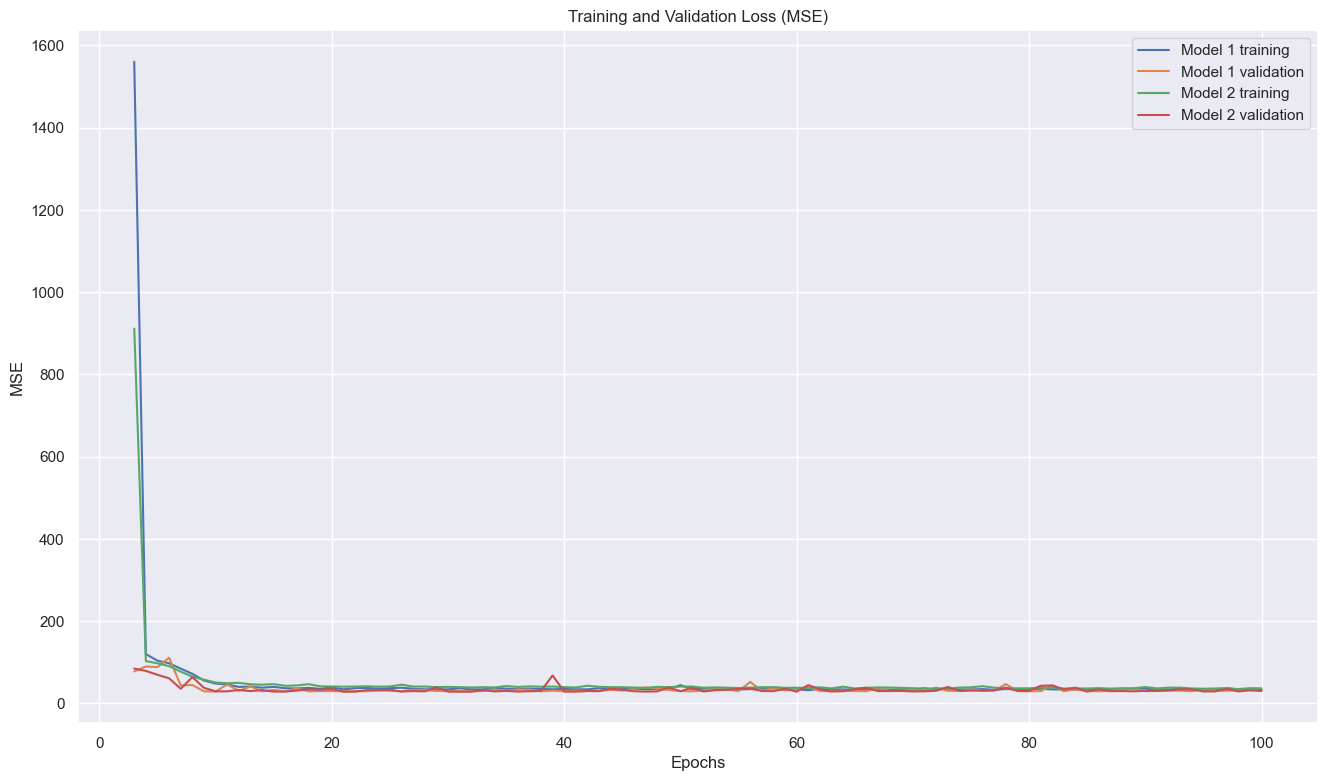

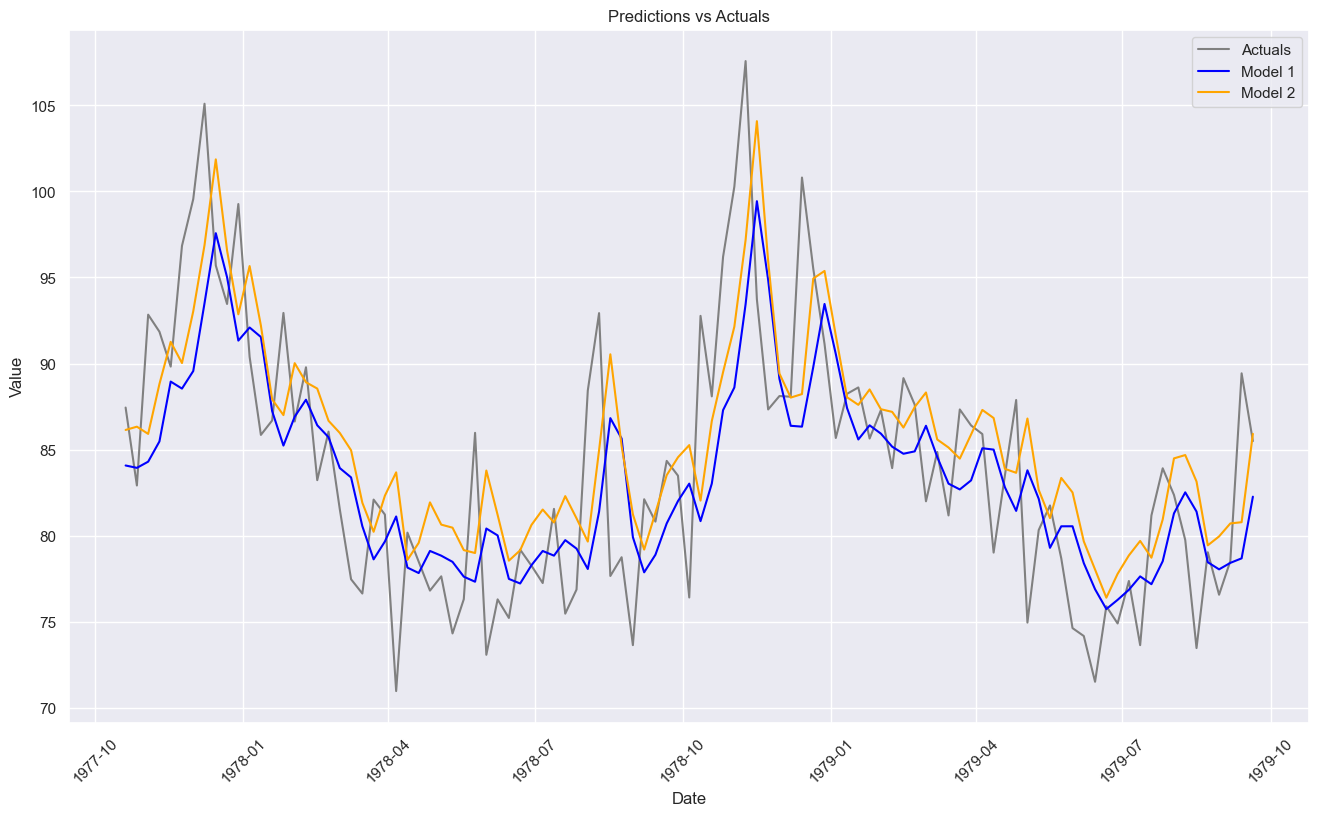

MAE      RMSE      MAPE
0  4.265606  5.495065  0.049784
1  4.403641  5.528877  0.052728

In [14]:
df_predictions1, train_loss1, val_loss1 = main(filename="mort.csv", reccurent_layer=LSTM(46), batch_size=6, window_size=4)
df_predictions2, train_loss2, val_loss2 = main(filename="mort.csv", reccurent_layer=LSTM(46), batch_size=6, window_size=2)

plot_loss(train_loss1, val_loss1, train_loss2, val_loss2)
plot_predictions(df_predictions1, df_predictions2)
evaluate_metrics(df_predictions1, df_predictions2)